Loading and preprocessing data...
Loading datasets...
Original shapes:
Training data shape: (27455, 785)
Test data shape: (7172, 785)

Processed shapes:
X_train shape: (27455, 784)
y_train_onehot shape: (27455, 24)

Visualizing random samples from dataset:


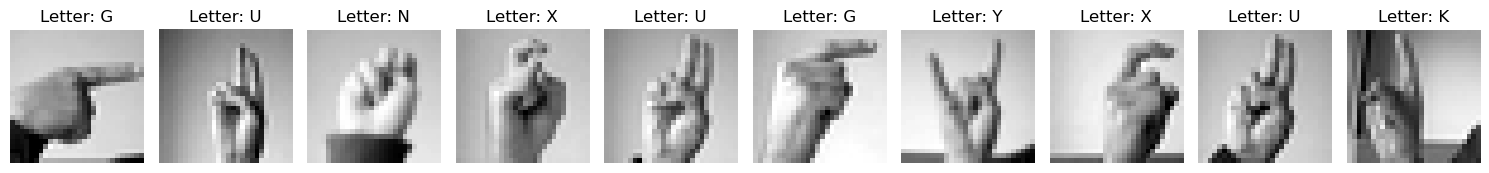


Initializing Neural Network Parameters...

Training Neural Network...


KeyboardInterrupt: 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def load_and_preprocess_data():
    """
    Load and preprocess the Sign Language MNIST dataset
    """
    print("Loading datasets...")
    # Load data and convert to float32 for better performance
    train_data = pd.read_csv('sign_mnist_train.csv').astype(np.float32)
    test_data = pd.read_csv('sign_mnist_test.csv').astype(np.float32)

    print("Original shapes:")
    print(f"Training data shape: {train_data.shape}")
    print(f"Test data shape: {test_data.shape}")

    # Separate features and labels
    X_train = train_data.drop('label', axis=1).values / 255.0
    y_train = train_data['label'].values.astype(np.int32)
    X_test = test_data.drop('label', axis=1).values / 255.0
    y_test = test_data['label'].values.astype(np.int32)

    # Convert labels to one-hot encoding
    def to_one_hot(y, num_classes=24):
        # Adjust labels for J(9) and Z(25) exclusion
        y = y - (y > 9) - (y > 24)
        return np.eye(num_classes)[y]

    y_train_onehot = to_one_hot(y_train)
    y_test_onehot = to_one_hot(y_test)

    print("\nProcessed shapes:")
    print(f"X_train shape: {X_train.shape}")
    print(f"y_train_onehot shape: {y_train_onehot.shape}")

    return X_train, y_train_onehot, y_train, X_test, y_test_onehot, y_test

def sigmoid(z):
    """
    Compute sigmoid activation function
    """
    z = np.clip(z, -500, 500)  # Prevent overflow
    return 1.0 / (1.0 + np.exp(-z))

def sigmoidGradient(z):
    """
    Compute gradient of sigmoid function
    """
    s = sigmoid(z)
    return s * (1 - s)

def randInitializeWeights(L_in, L_out):
    """
    Randomly initialize weights using Xavier initialization
    """
    epsilon = np.sqrt(6) / np.sqrt(L_in + L_out)
    W = np.random.rand(L_out, L_in + 1) * 2 * epsilon - epsilon
    return W.astype(np.float32)  # Convert to float32 for better performance

def nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, Lambda):
    """
    Neural network cost function
    """
    # Reshape nn_params back into the parameters Theta1 and Theta2
    Theta1 = nn_params[:((input_layer_size + 1) * hidden_layer_size)].reshape(
        hidden_layer_size, input_layer_size + 1)
    Theta2 = nn_params[((input_layer_size + 1) * hidden_layer_size):].reshape(
        num_labels, hidden_layer_size + 1)

    m = X.shape[0]

    # Forward propagation
    a1 = np.hstack([np.ones((m, 1)), X])
    z2 = a1 @ Theta1.T
    a2 = np.hstack([np.ones((m, 1)), sigmoid(z2)])
    z3 = a2 @ Theta2.T
    h = sigmoid(z3)

    # Compute cost
    cost = -np.mean(y * np.log(h + 1e-15) + (1 - y) * np.log(1 - h + 1e-15))
    reg_term = (Lambda/(2*m)) * (np.sum(Theta1[:,1:]**2) + np.sum(Theta2[:,1:]**2))
    reg_J = cost + reg_term

    # Backpropagation
    delta3 = h - y
    delta2 = (delta3 @ Theta2)[:, 1:] * sigmoidGradient(z2)

    # Compute gradients
    Theta2_grad = (1/m) * (delta3.T @ a2)
    Theta1_grad = (1/m) * (delta2.T @ a1)

    # Add regularization to gradients
    Theta2_grad[:, 1:] += (Lambda/m) * Theta2[:, 1:]
    Theta1_grad[:, 1:] += (Lambda/m) * Theta1[:, 1:]

    # Unroll gradients
    grad = np.concatenate([Theta1_grad.ravel(), Theta2_grad.ravel()])

    return reg_J, grad

def predict(Theta1, Theta2, X):
    """
    Predict labels using trained weights
    """
    m = X.shape[0]
    X = np.hstack([np.ones((m, 1)), X])

    h1 = sigmoid(X @ Theta1.T)
    h1 = np.hstack([np.ones((m, 1)), h1])
    h2 = sigmoid(h1 @ Theta2.T)

    return np.argmax(h2, axis=1)

def gradientDescent(X, y, initial_nn_params, alpha, num_iters, Lambda, input_layer_size,
                   hidden_layer_size, num_labels, batch_size=128):
    """
    Gradient descent with mini-batches
    """
    m = X.shape[0]
    nn_params = initial_nn_params.copy()
    J_history = []

    for i in range(num_iters):
        # Shuffle data
        indices = np.random.permutation(m)
        X = X[indices]
        y = y[indices]

        # Mini-batch processing
        batch_costs = []
        for batch_start in range(0, m, batch_size):
            batch_end = min(batch_start + batch_size, m)
            X_batch = X[batch_start:batch_end]
            y_batch = y[batch_start:batch_end]

            # Compute cost and gradient
            cost, grad = nnCostFunction(nn_params, input_layer_size, hidden_layer_size,
                                      num_labels, X_batch, y_batch, Lambda)

            # Update parameters
            nn_params = nn_params - alpha * grad
            batch_costs.append(cost)

        # Store mean batch cost
        J_history.append(np.mean(batch_costs))


        print(f"Iteration {i+1}, Cost: {J_history[-1]:.4f}")

    return nn_params, J_history

def visualize_sample(X, y, num_samples=10):
    """
    Visualize random samples from dataset
    """
    letters = 'ABCDEFGHIKLMNOPQRSTUVWXY'  # Excluding J and Z
    indices = np.random.randint(0, len(y), num_samples)

    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(indices):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(X[idx].reshape(28, 28), cmap='gray')
        label = y[idx]
        if label > 9:  # After J
            label -= 1
        if label > 24:  # After Z
            label -= 1
        plt.title(f'Letter: {letters[label]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Load and preprocess data
    print("Loading and preprocessing data...")
    X_train, y_train_onehot, y_train, X_test, y_test_onehot, y_test = load_and_preprocess_data()

    # Visualize samples
    print("\nVisualizing random samples from dataset:")
    visualize_sample(X_train, y_train)

    # Network parameters
    input_layer_size = 784  # 28x28 pixels
    hidden_layer_size = 100
    num_labels = 24        # 24 letters (excluding J and Z)

    print("\nInitializing Neural Network Parameters...")
    initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
    initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)

    # Unroll parameters
    initial_nn_params = np.concatenate([initial_Theta1.ravel(), initial_Theta2.ravel()]).astype(np.float32)

    print("\nTraining Neural Network...")
    nn_params, J_history = gradientDescent(
        X_train, y_train_onehot,
        initial_nn_params,
        alpha=0.01,
        num_iters=50,
        Lambda=0.1,
        input_layer_size=input_layer_size,
        hidden_layer_size=hidden_layer_size,
        num_labels=num_labels,
        batch_size=128
    )

    # Reshape trained parameters
    Theta1 = nn_params[:((input_layer_size + 1) * hidden_layer_size)].reshape(
        hidden_layer_size, input_layer_size + 1)
    Theta2 = nn_params[((input_layer_size + 1) * hidden_layer_size):].reshape(
        num_labels, hidden_layer_size + 1)

    # Plot training progress
    plt.figure(figsize=(10, 5))
    plt.plot(J_history)
    plt.xlabel('Iteration')
    plt.ylabel('Cost J')
    plt.title('Cost Function during Training')
    plt.grid(True)
    plt.show()

    # Calculate training accuracy
    pred_train = predict(Theta1, Theta2, X_train)
    train_accuracy = np.mean(pred_train == np.argmax(y_train_onehot, axis=1)) * 100
    print(f'\nTraining Set Accuracy: {train_accuracy:.2f}%')

    # Calculate test accuracy
    pred_test = predict(Theta1, Theta2, X_test)
    test_accuracy = np.mean(pred_test == np.argmax(y_test_onehot, axis=1)) * 100
    print(f'Test Set Accuracy: {test_accuracy:.2f}%')

    # Save the model parameters
    model_params = {
        'Theta1': Theta1,
        'Theta2': Theta2,
        'input_layer_size': input_layer_size,
        'hidden_layer_size': hidden_layer_size,
        'num_labels': num_labels
    }
    np.save('sign_language_model.npy', model_params)
    print('\nModel parameters saved to sign_language_model.npy')